## Importing the modules

In [1]:
import pandas as pd
import requests
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import glob
import os
from pyproj import Transformer
import time
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score

model_dir = '/content/drive/My Drive/data science project/models'   # change to whatever folder you like
os.makedirs(model_dir, exist_ok=True)

import joblib

Mounted at /content/drive


## Reading the Property sale data 2023

In [2]:
csv_file = "/content/drive/MyDrive/data science project/pp-2023.csv"
land_registry_df = pd.read_csv(csv_file, header=None)
print(land_registry_df.shape)  # The number of rows and columns

(812766, 16)


 ##### Link to the header file https://www.gov.uk/guidance/about-the-price-paid-data




In [3]:
land_registry_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,{06C9F487-D94B-9388-E063-4804A8C0BD98},330000,2023-03-20 00:00,CF14 7BX,T,N,F,32,NaN,HEOL PANT Y CELYN,NaN,CARDIFF,CARDIFF,CARDIFF,A,A
1,{06C9F487-D94C-9388-E063-4804A8C0BD98},269950,2023-07-25 00:00,LL28 4SH,D,N,F,7,NaN,MARSTON DRIVE,RHOS ON SEA,COLWYN BAY,CONWY,CONWY,A,A
2,{06C9F487-D94D-9388-E063-4804A8C0BD98},280000,2023-08-10 00:00,LL31 9BN,D,N,F,PLAS COLWYN,NaN,LLYS HELYG,DEGANWY,CONWY,CONWY,CONWY,A,A
3,{06C9F487-D94E-9388-E063-4804A8C0BD98},699999,2023-08-24 00:00,SA62 6BA,D,N,F,MIDDLE LOCHVANE,NaN,NaN,PEN Y CWM,HAVERFORDWEST,PEMBROKESHIRE,PEMBROKESHIRE,A,A
4,{06C9F487-D94F-9388-E063-4804A8C0BD98},160000,2023-08-21 00:00,SY16 1QY,T,N,F,167,NaN,LON DOLAFON,NaN,NEWTOWN,POWYS,POWYS,A,A


In [4]:
land_registry_df.columns = ['Transaction unique identifier','Price','Date of Transfer',
                            'Postcode','PropertyType','Old/New','Duration','PAON','SAON',
                            'Street','Locality','Town/city','District','County','PPD Category Type','Record Status-monthly file only']

In [5]:
land_registry_df.head()

,Transaction unique identifier,Price,Date of Transfer,Postcode,PropertyType,Old/New,Duration,PAON,SAON,Street,Locality,Town/city,District,County,PPD Category Type,Record Status-monthly file only
0,{06C9F487-D94B-9388-E063-4804A8C0BD98},330000,2023-03-20 00:00,CF14 7BX,T,N,F,32,NaN,HEOL PANT Y CELYN,NaN,CARDIFF,CARDIFF,CARDIFF,A,A
1,{06C9F487-D94C-9388-E063-4804A8C0BD98},269950,2023-07-25 00:00,LL28 4SH,D,N,F,7,NaN,MARSTON DRIVE,RHOS ON SEA,COLWYN BAY,CONWY,CONWY,A,A
2,{06C9F487-D94D-9388-E063-4804A8C0BD98},280000,2023-08-10 00:00,LL31 9BN,D,N,F,PLAS COLWYN,NaN,LLYS HELYG,DEGANWY,CONWY,CONWY,CONWY,A,A
3,{06C9F487-D94E-9388-E063-4804A8C0BD98},699999,2023-08-24 00:00,SA62 6BA,D,N,F,MIDDLE LOCHVANE,NaN,NaN,PEN Y CWM,HAVERFORDWEST,PEMBROKESHIRE,PEMBROKESHIRE,A,A
4,{06C9F487-D94F-9388-E063-4804A8C0BD98},160000,2023-08-21 00:00,SY16 1QY,T,N,F,167,NaN,LON DOLAFON,NaN,NEWTOWN,POWYS,POWYS,A,A


## Reading the Stops data

#### The data is taken from NapTan (National Public Transport access nodes) in the government website.
#### This data is used to know about the nearest public stops.


In [6]:
csv_file = "/content/drive/MyDrive/data science project/Stops.csv"
Stops = pd.read_csv(csv_file)
print(Stops.shape)

<ipython-input-6-ee71dce86309>:2: DtypeWarning: Columns (1,2,6,8,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  Stops = pd.read_csv(csv_file)


(435436, 43)


In [7]:
Stops.head()

,ATCOCode,NaptanCode,PlateCode,CleardownCode,CommonName,CommonNameLang,ShortCommonName,ShortCommonNameLang,Landmark,LandmarkLang,...,TimingStatus,DefaultWaitTime,Notes,NotesLang,AdministrativeAreaCode,CreationDateTime,ModificationDateTime,RevisionNumber,Modification,Status
0,0100BRP90312,bstjaja,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2009-08-25T00:00:00,2020-11-26T13:23:29,45.0,new,active
1,0100BRP90313,bstjama,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2009-08-25T00:00:00,2020-11-26T13:22:13,44.0,new,active
2,0100BRP90310,bstgwpa,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2009-08-25T00:00:00,2023-04-21T18:02:19,99.0,new,active
3,0100BRP90311,bstgwpm,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2009-08-25T00:00:00,2019-09-13T10:41:38,73.0,new,active
4,010000056,bstpjgw,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2019-08-06T00:00:00,2019-08-06T11:09:11,120.0,new,active


In [8]:
Stops.columns

Index(['ATCOCode', 'NaptanCode', 'PlateCode', 'CleardownCode', 'CommonName',
       'CommonNameLang', 'ShortCommonName', 'ShortCommonNameLang', 'Landmark',
       'LandmarkLang', 'Street', 'StreetLang', 'Crossing', 'CrossingLang',
       'Indicator', 'IndicatorLang', 'Bearing', 'NptgLocalityCode',
       'LocalityName', 'ParentLocalityName', 'GrandParentLocalityName', 'Town',
       'TownLang', 'Suburb', 'SuburbLang', 'LocalityCentre', 'GridType',
       'Easting', 'Northing', 'Longitude', 'Latitude', 'StopType',
       'BusStopType', 'TimingStatus', 'DefaultWaitTime', 'Notes', 'NotesLang',
       'AdministrativeAreaCode', 'CreationDateTime', 'ModificationDateTime',
       'RevisionNumber', 'Modification', 'Status'],
      dtype='object')

## Reading the School data

#### This data is taken from Ofsted(the Office for Standards in Education, Children's Services and Skills)

#### From this data, the main focus is to get the nearest school or college

In [9]:
csv_file2 = "/content/drive/MyDrive/data science project/2023-2024_england_school_information.csv"
schools = pd.read_csv(csv_file2)
schools.shape

(25489, 26)

## Data preprocessing



### Data type Inspection

#### The required latitudes and longitude columns are in numerical data types. So, its better to proceed further .

In [10]:
Stops.dtypes

,0
ATCOCode,object
NaptanCode,object
PlateCode,object
CleardownCode,float64
CommonName,object
CommonNameLang,float64
ShortCommonName,object
ShortCommonNameLang,float64
Landmark,object
LandmarkLang,float64


In [11]:
print(Stops[['CommonName','Longitude','Latitude']])

                               CommonName  Longitude   Latitude
0                        Temple Meads Stn  -2.582620  51.448980
1                        Temple Meads Stn  -2.581770  51.449440
2                        Temple Meads Stn  -2.585790  51.449020
3                        Temple Meads Stn  -2.585600  51.450140
4                        Temple Meads Stn  -2.584890  51.449670
...                                   ...        ...        ...
435431    Talbot Road (Blackpool Tramway)  -3.054507  53.819144
435432    Talbot Road (Blackpool Tramway)  -3.054537  53.819135
435433  North Station (Blackpool Tramway)  -3.050058  53.821035
435434  North Station (Blackpool Tramway)  -3.050088  53.821034
435435  North Station (Blackpool Tramway)  -3.050027  53.821035

[435436 rows x 3 columns]


### Inspection on land registry data
#### The price column is numerical.
#### The latitude and longitude columns are not present in the data. So,by using a code-point open dataset I got the latritudes and longitudes for each post code in my land registry dataset.   

In [12]:
land_registry_df.dtypes

,0
Transaction unique identifier,object
Price,int64
Date of Transfer,object
Postcode,object
PropertyType,object
Old/New,object
Duration,object
PAON,object
SAON,object
Street,object


In [13]:
print(land_registry_df[['Postcode','Price','Town/city','District','County']])

        Postcode   Price      Town/city       District          County
0       CF14 7BX  330000        CARDIFF        CARDIFF         CARDIFF
1       LL28 4SH  269950     COLWYN BAY          CONWY           CONWY
2       LL31 9BN  280000          CONWY          CONWY           CONWY
3       SA62 6BA  699999  HAVERFORDWEST  PEMBROKESHIRE   PEMBROKESHIRE
4       SY16 1QY  160000        NEWTOWN          POWYS           POWYS
...          ...     ...            ...            ...             ...
812761  LS12 4FJ  235000          LEEDS          LEEDS  WEST YORKSHIRE
812762   LS4 2EJ  229995          LEEDS          LEEDS  WEST YORKSHIRE
812763   WF7 5QE  253995     PONTEFRACT      WAKEFIELD  WEST YORKSHIRE
812764  LS12 4FL  270000          LEEDS          LEEDS  WEST YORKSHIRE
812765  LS25 4EP  279995          LEEDS          LEEDS  WEST YORKSHIRE

[812766 rows x 5 columns]


### Postcodes to latitude & Longitude conversion

#### link https://osdatahub.os.uk/downloads/open/CodePointOpen


In [14]:
folder_path = "/content/drive/MyDrive/data science project/CSV/"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

df_list = []
for file in csv_files:
    temp_df = pd.read_csv(file)
    df_list.append(temp_df)


#d=[]
#for i in df_list[:-1]:
#  d.append(i.values)
master_columns = ['Postcode','Positional_quality_indicator','Eastings','Northings','Countrycode','NHS_reg_HA_code','NHS_code','Admin_county',
                  'Admin_dist','Admin_ward']
combined_data = np.concatenate(df_list[:-1], axis=0)
df_combined = pd.DataFrame(combined_data,columns = master_columns )

<ipython-input-14-81858be88917>:6: DtypeWarning: Columns (0,4,5,6,7,8,9,10,13,14,15,16,17,20,21,22,25,26,27,30,31,32,33,36,37,38,41,42,43,46,47,48,49,52,53,54,55,56,59,61,62,63,64,67,68,69,72,73) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(file)


In [15]:
df_list

[        B1 1AY  10  406523  286448  E92000001  E19000001  E18000005  \
 0       B1 1BA  10  406875  286393  E92000001  E19000001  E18000005   
 1       B1 1BB  10  406654  286948  E92000001  E19000001  E18000005   
 2       B1 1BD  10  406689  286781  E92000001  E19000001  E18000005   
 3       B1 1BE  10  406721  286611  E92000001  E19000001  E18000005   
 4       B1 1BL  10  406779  286550  E92000001  E19000001  E18000005   
 ...        ...  ..     ...     ...        ...        ...        ...   
 41898  B99 1DN  10  407279  288677  E92000001  E19000001  E18000005   
 41899  B99 1DP  10  407279  288677  E92000001  E19000001  E18000005   
 41900  B99 1DQ  10  407279  288677  E92000001  E19000001  E18000005   
 41901  B99 1DS  10  407279  288677  E92000001  E19000001  E18000005   
 41902  B99 1DW  10  407279  288677  E92000001  E19000001  E18000005   
 
       Unnamed: 7  E08000025  E05011151  
 0            NaN  E08000025  E05011151  
 1            NaN  E08000025  E05011151  
 2      

In [16]:

len(df_list)

121

In [17]:
len(combined_data)

1742605

In [18]:
df_combined

,Postcode,Positional_quality_indicator,Eastings,Northings,Countrycode,NHS_reg_HA_code,NHS_code,Admin_county,Admin_dist,Admin_ward
0,B1 1BA,10,406875,286393,E92000001,E19000001,E18000005,NaN,E08000025,E05011151
1,B1 1BB,10,406654,286948,E92000001,E19000001,E18000005,NaN,E08000025,E05011151
2,B1 1BD,10,406689,286781,E92000001,E19000001,E18000005,NaN,E08000025,E05011151
3,B1 1BE,10,406721,286611,E92000001,E19000001,E18000005,NaN,E08000025,E05011151
4,B1 1BL,10,406779,286550,E92000001,E19000001,E18000005,NaN,E08000025,E05011151
...,...,...,...,...,...,...,...,...,...,...
1742600,TS9 7LL,10,458129,495552,E92000001,E19000001,E18000003,NaN,E06000065,E05014276
1742601,TS9 7LN,10,458201,496162,E92000001,E19000001,E18000003,NaN,E06000065,E05014276
1742602,TS9 7LQ,10,457418,493546,E92000001,E19000001,E18000003,NaN,E06000065,E05014276
1742603,TS9 7LW,10,458229,497257,E92000001,E19000001,E18000003,NaN,E06000065,E05014276


In [19]:
df_combined[['Postcode','Eastings','Northings']]

,Postcode,Eastings,Northings
0,B1 1BA,406875,286393
1,B1 1BB,406654,286948
2,B1 1BD,406689,286781
3,B1 1BE,406721,286611
4,B1 1BL,406779,286550
...,...,...,...
1742600,TS9 7LL,458129,495552
1742601,TS9 7LN,458201,496162
1742602,TS9 7LQ,457418,493546
1742603,TS9 7LW,458229,497257


EPSG:27700 = Ordnance Survey National Grid (UK) in metres

EPSG:4326 = WGS-84 latitude/longitude used by GPS & web maps

Result: an object that converts UK grid eastings/northings → decimal-degree lon/lat.

In [20]:
transformer = Transformer.from_crs("EPSG:27700", "EPSG:4326", always_xy=True)

coor= []
for i,j in df_combined[['Eastings','Northings']].values:
  lon, lat = transformer.transform(i, j)
  coor.append([lon,lat])

new_columns = pd.DataFrame(coor, columns=['Longitude_prop', 'Latitude_prop'])

rep = pd.concat([new_columns] * (len(df_combined) // len(new_columns) + 1), ignore_index=True).head(len(df_combined))
all_postcodes = pd.concat([df_combined, rep], axis=1)

In [21]:
all_postcodes

,Postcode,Positional_quality_indicator,Eastings,Northings,Countrycode,NHS_reg_HA_code,NHS_code,Admin_county,Admin_dist,Admin_ward,Longitude_prop,Latitude_prop
0,B1 1BA,10,406875,286393,E92000001,E19000001,E18000005,NaN,E08000025,E05011151,-1.900211,52.475425
1,B1 1BB,10,406654,286948,E92000001,E19000001,E18000005,NaN,E08000025,E05011151,-1.903454,52.480418
2,B1 1BD,10,406689,286781,E92000001,E19000001,E18000005,NaN,E08000025,E05011151,-1.902941,52.478916
3,B1 1BE,10,406721,286611,E92000001,E19000001,E18000005,NaN,E08000025,E05011151,-1.902474,52.477387
4,B1 1BL,10,406779,286550,E92000001,E19000001,E18000005,NaN,E08000025,E05011151,-1.901621,52.476838
...,...,...,...,...,...,...,...,...,...,...,...,...
1742600,TS9 7LL,10,458129,495552,E92000001,E19000001,E18000003,NaN,E06000065,E05014276,-1.107158,54.352200
1742601,TS9 7LN,10,458201,496162,E92000001,E19000001,E18000003,NaN,E06000065,E05014276,-1.105932,54.357673
1742602,TS9 7LQ,10,457418,493546,E92000001,E19000001,E18000003,NaN,E06000065,E05014276,-1.118482,54.334254
1742603,TS9 7LW,10,458229,497257,E92000001,E19000001,E18000003,NaN,E06000065,E05014276,-1.105287,54.367510


In [22]:
all_postcodes_updated = all_postcodes[['Postcode','Longitude_prop','Latitude_prop']]

In [23]:
df_merged = land_registry_df.merge(all_postcodes_updated, on='Postcode', how='inner')

print("\nMerged DataFrame (Inner Join):")
df_merged


Merged DataFrame (Inner Join):


,Transaction unique identifier,Price,Date of Transfer,Postcode,PropertyType,Old/New,Duration,PAON,SAON,Street,Locality,Town/city,District,County,PPD Category Type,Record Status-monthly file only,Longitude_prop,Latitude_prop
0,{06C9F487-D94B-9388-E063-4804A8C0BD98},330000,2023-03-20 00:00,CF14 7BX,T,N,F,32,NaN,HEOL PANT Y CELYN,NaN,CARDIFF,CARDIFF,CARDIFF,A,A,-3.230427,51.521780
1,{06C9F487-D94C-9388-E063-4804A8C0BD98},269950,2023-07-25 00:00,LL28 4SH,D,N,F,7,NaN,MARSTON DRIVE,RHOS ON SEA,COLWYN BAY,CONWY,CONWY,A,A,-3.758625,53.307721
2,{06C9F487-D94D-9388-E063-4804A8C0BD98},280000,2023-08-10 00:00,LL31 9BN,D,N,F,PLAS COLWYN,NaN,LLYS HELYG,DEGANWY,CONWY,CONWY,CONWY,A,A,-3.834173,53.300155
3,{06C9F487-D94E-9388-E063-4804A8C0BD98},699999,2023-08-24 00:00,SA62 6BA,D,N,F,MIDDLE LOCHVANE,NaN,NaN,PEN Y CWM,HAVERFORDWEST,PEMBROKESHIRE,PEMBROKESHIRE,A,A,-5.165292,51.870469
4,{06C9F487-D94F-9388-E063-4804A8C0BD98},160000,2023-08-21 00:00,SY16 1QY,T,N,F,167,NaN,LON DOLAFON,NaN,NEWTOWN,POWYS,POWYS,A,A,-3.341036,52.508779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809924,{152AB734-65BF-E651-E063-4704A8C061D9},235000,2023-03-07 00:00,LS12 4FJ,T,Y,F,37,NaN,BOBBIN ROW,NaN,LEEDS,LEEDS,WEST YORKSHIRE,A,A,-1.612370,53.791536
809925,{152AB734-65C0-E651-E063-4704A8C061D9},229995,2023-04-21 00:00,LS4 2EJ,F,Y,L,BLOCK B ALEXANDRA PARK,FLAT B204,WILLOW ROAD,NaN,LEEDS,LEEDS,WEST YORKSHIRE,A,A,-1.575933,53.805668
809926,{152AB734-65C2-E651-E063-4704A8C061D9},253995,2023-04-24 00:00,WF7 5QE,D,Y,F,4,NaN,MILLER ROAD,FEATHERSTONE,PONTEFRACT,WAKEFIELD,WEST YORKSHIRE,A,A,-1.352843,53.678055
809927,{152AB734-65C3-E651-E063-4704A8C061D9},270000,2023-03-24 00:00,LS12 4FL,T,Y,F,19,NaN,PARK MEADOW LANE,NaN,LEEDS,LEEDS,WEST YORKSHIRE,A,A,-1.610767,53.790928


In [24]:
schools.rename(columns={'POSTCODE': 'Postcode'}, inplace=True)

In [25]:
school_merged = schools.merge(all_postcodes_updated, on='Postcode', how='inner')

print("\nMerged DataFrame (Inner Join):")
school_merged.head()


Merged DataFrame (Inner Join):


,URN,LANAME,LA,ESTAB,LAESTAB,SCHNAME,STREET,LOCALITY,ADDRESS3,TOWN,...,ISPOST16,AGELOW,AGEHIGH,GENDER,RELCHAR,ADMPOL,OFSTEDRATING,OFSTEDLASTINSP,Longitude_prop,Latitude_prop
0,100000,City of London,201,3614,2013614,The Aldgate School,St James's Passage,Duke's Place,NaN,London,...,0,3.0,11.0,Mixed,Church of England,Not applicable,Outstanding,12-06-2024,-0.077486,51.513662
1,100001,City of London,201,6005,2016005,City of London School for Girls,St Giles' Terrace,Barbican,NaN,London,...,1,7.0,18.0,Girls,NaN,Selective,NaN,NaN,-0.094509,51.519129
2,100002,City of London,201,6006,2016006,St Paul's Cathedral School,2 New Change,NaN,NaN,London,...,0,4.0,13.0,Mixed,Church of England,Not applicable,NaN,NaN,-0.096820,51.513834
3,100003,City of London,201,6007,2016007,City of London School,107 Queen Victoria Street,NaN,NaN,London,...,1,10.0,18.0,Boys,NaN,Not applicable,NaN,NaN,-0.099387,51.511025
4,100008,Camden,202,2019,2022019,Argyle Primary School,Tonbridge Street,NaN,NaN,London,...,0,3.0,11.0,Mixed,Does not apply,Not applicable,Good,04-10-2022,-0.124037,51.528750


### Checking the null values

In [26]:
print('_________ Land registry merged data __________\n')
print(df_merged.isnull().sum())
print('\n ___________ Stops ______________\n')
print(Stops.isnull().sum())
print('\n _______________   School merged data ____________\n')
print(school_merged.isnull().sum())

_________ Land registry merged data __________

Transaction unique identifier           0
Price                                   0
Date of Transfer                        0
Postcode                                0
PropertyType                            0
Old/New                                 0
Duration                                0
PAON                                    0
SAON                               703022
Street                              12927
Locality                           506337
Town/city                               0
District                                0
County                                  0
PPD Category Type                       0
Record Status-monthly file only         0
Longitude_prop                          0
Latitude_prop                           0
dtype: int64

 ___________ Stops ______________

ATCOCode                        0
NaptanCode                  25721
PlateCode                  372481
CleardownCode              435436
CommonName 

In [27]:
Stops.dropna(subset = ['Latitude', 'Longitude'], how='all',inplace=True)

### Top 30 Towns

In [28]:
df_merged['Town/city'].value_counts()

,count
Town/city,
LONDON,55479
MANCHESTER,13510
BRISTOL,12437
BIRMINGHAM,11434
NOTTINGHAM,11160
...,...
MINDRUM,2
MARIANGLAS,2
LYDBURY NORTH,2


In [29]:
df_merged['Town/city'].value_counts()[1116:1146]

,count
Town/city,
HOLMROOK,11
GARNDOLBENMAEN,11
LLANGAMMARCH WELLS,11
CLARBESTON ROAD,11
DYFFRYN ARDUDWY,11
LLWYNGWRIL,11
MEIFOD,10
LLANARTH,9
DOLWYDDELAN,9


In [30]:
top_30 = pd.DataFrame(df_merged['Town/city'].value_counts()[:30]).reset_index()
locations = top_30['Town/city'].values

In [31]:
locations

array(['LONDON', 'MANCHESTER', 'BRISTOL', 'BIRMINGHAM', 'NOTTINGHAM',
       'LIVERPOOL', 'LEEDS', 'SHEFFIELD', 'LEICESTER',
       'NEWCASTLE UPON TYNE', 'NORWICH', 'SOUTHAMPTON', 'STOKE-ON-TRENT',
       'PRESTON', 'DERBY', 'DONCASTER', 'CARDIFF', 'READING', 'HULL',
       'COVENTRY', 'NORTHAMPTON', 'YORK', 'BRADFORD', 'PLYMOUTH',
       'SWINDON', 'BOLTON', 'PETERBOROUGH', 'MILTON KEYNES', 'STOCKPORT',
       'CAMBRIDGE'], dtype=object)

In [32]:
filtered_df = df_merged[df_merged['Town/city'].isin(locations)]

### Creating New columns

### DISTANCE calculation betweeen Stops data and land registry data
#### CKD tree is used to find the nearest neighbour

In [33]:
def latlon_to_cartesian(lat, lon, R=6371.0):
    lat_radians = np.radians(lat)
    lon_radians = np.radians(lon)
    x = R * np.cos(lat_radians) * np.cos(lon_radians)
    y = R * np.cos(lat_radians) * np.sin(lon_radians)
    z = R * np.sin(lat_radians)
    return x, y, z

In [34]:
# Build station coords & KDTree
sx, sy, sz = latlon_to_cartesian(Stops['Latitude'], Stops['Longitude'])
station_coords = np.column_stack((sx, sy, sz))
tree = cKDTree(station_coords)

In [35]:

# Convert properties to 3D
# FILTERED_DF IS THE LAND REGISTRY FINAL DATA
px, py, pz = latlon_to_cartesian(filtered_df['Latitude_prop'], filtered_df['Longitude_prop'])
prop_coords = np.column_stack((px, py, pz))

In [36]:
# Query tree
distances, indices = tree.query(prop_coords, k=1)

# Attach results
filtered_df['nearest_station_index'] = indices
filtered_df['nearest_station_km'] = distances
filtered_df['closest_station'] = filtered_df['nearest_station_index'].apply(
    lambda i: Stops.iloc[i]['CommonName'] if i >= 0 else None
)


<ipython-input-36-b264be49590e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['nearest_station_index'] = indices
<ipython-input-36-b264be49590e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['nearest_station_km'] = distances
<ipython-input-36-b264be49590e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

###  DISTANCE calculation betweeen Schools data and land registry data

In [37]:
# Build station coords & KDTree
sx1, sy1, sz1 = latlon_to_cartesian(school_merged['Latitude_prop'], school_merged['Longitude_prop'])
school_coords = np.column_stack((sx1, sy1, sz1))
tree1 = cKDTree(school_coords)

In [38]:
# Convert properties to 3D
px1, py1, pz1 = latlon_to_cartesian(filtered_df['Latitude_prop'], filtered_df['Longitude_prop'])
prop_coords1 = np.column_stack((px1, py1, pz1))

In [39]:
# Query tree
distances1, indices1 = tree1.query(prop_coords1, k=1)

# Attach results
filtered_df['nearest_school_index'] = indices1
filtered_df['dist_school_km'] = distances1
filtered_df['closest_school'] = filtered_df['nearest_school_index'].apply(
    lambda i: school_merged.iloc[i]['SCHNAME'] if i >= 0 else None
)

<ipython-input-39-7d80b88ed0f8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['nearest_school_index'] = indices1
<ipython-input-39-7d80b88ed0f8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dist_school_km'] = distances1
<ipython-input-39-7d80b88ed0f8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [40]:
filtered_df.to_csv("/content/drive/MyDrive/data science project/final registry data.csv")

In [41]:
filtered_df.head()

,Transaction unique identifier,Price,Date of Transfer,Postcode,PropertyType,Old/New,Duration,PAON,SAON,Street,...,PPD Category Type,Record Status-monthly file only,Longitude_prop,Latitude_prop,nearest_station_index,nearest_station_km,closest_station,nearest_school_index,dist_school_km,closest_school
0,{06C9F487-D94B-9388-E063-4804A8C0BD98},330000,2023-03-20 00:00,CF14 7BX,T,N,F,32,NaN,HEOL PANT Y CELYN,...,A,A,-3.230427,51.521780,337034,0.127737,Hollybush Inn,11749,25.660944,Weston College
10,{06C9F487-D956-9388-E063-4804A8C0BD98},247600,2023-08-04 00:00,CF14 3DX,S,N,F,29,NaN,MYNACHDY ROAD,...,A,A,-3.198424,51.500207,337266,0.049774,Wyfan Place,11749,22.396198,Weston College
24,{06C9F487-D965-9388-E063-4804A8C0BD98},465000,2023-08-16 00:00,CF14 1SB,D,N,F,6,NaN,HEOL PEN Y FAI,...,A,A,-3.208879,51.510899,337052,0.170733,Ararat Church,11749,23.764113,Weston College
30,{06C9F487-D96C-9388-E063-4804A8C0BD98},320000,2023-08-03 00:00,CF15 9EJ,D,N,F,2,NaN,MAES Y NANT,...,A,A,-3.327394,51.521451,337712,0.145621,Llys Gwynno,11749,30.564809,Weston College
49,{06C9F487-DB19-9388-E063-4804A8C0BD98},210000,2023-05-19 00:00,CF5 4EA,S,N,F,62,NaN,LLEWELLYN AVENUE,...,A,A,-3.255042,51.483366,337504,0.219598,Archer Road,11749,24.011408,Weston College


### Checking the null values

#### These three columns have a lot of data missing in it. Its better to remove them instead of imputing it.

In [42]:
filtered_df.isnull().sum()

,0
Transaction unique identifier,0
Price,0
Date of Transfer,0
Postcode,0
PropertyType,0
Old/New,0
Duration,0
PAON,0
SAON,192235
Street,518


In [43]:
filtered_df.shape

(237891, 24)

In [44]:
filtered_df.dropna(axis=1, how='any', inplace=True)

<ipython-input-44-cb32969b3a97>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.dropna(axis=1, how='any', inplace=True)


In [45]:
filtered_df.shape

(237891, 21)

In [46]:
filtered_df.isnull().sum()

,0
Transaction unique identifier,0
Price,0
Date of Transfer,0
Postcode,0
PropertyType,0
Old/New,0
Duration,0
PAON,0
Town/city,0
District,0


### Working on Date column

In [47]:
# Convert to pandas datetime
final_df = filtered_df.copy()
final_df['Date of Transfer'] = pd.to_datetime(final_df['Date of Transfer'], format='%Y-%m-%d %H:%M')

# Extract year and month
#final_df['year'] = final_df['Date of Transfer'].dt.year
final_df['month'] = final_df['Date of Transfer'].dt.month

final_df.head()

,Transaction unique identifier,Price,Date of Transfer,Postcode,PropertyType,Old/New,Duration,PAON,Town/city,District,...,Record Status-monthly file only,Longitude_prop,Latitude_prop,nearest_station_index,nearest_station_km,closest_station,nearest_school_index,dist_school_km,closest_school,month
0,{06C9F487-D94B-9388-E063-4804A8C0BD98},330000,2023-03-20,CF14 7BX,T,N,F,32,CARDIFF,CARDIFF,...,A,-3.230427,51.521780,337034,0.127737,Hollybush Inn,11749,25.660944,Weston College,3
10,{06C9F487-D956-9388-E063-4804A8C0BD98},247600,2023-08-04,CF14 3DX,S,N,F,29,CARDIFF,CARDIFF,...,A,-3.198424,51.500207,337266,0.049774,Wyfan Place,11749,22.396198,Weston College,8
24,{06C9F487-D965-9388-E063-4804A8C0BD98},465000,2023-08-16,CF14 1SB,D,N,F,6,CARDIFF,CARDIFF,...,A,-3.208879,51.510899,337052,0.170733,Ararat Church,11749,23.764113,Weston College,8
30,{06C9F487-D96C-9388-E063-4804A8C0BD98},320000,2023-08-03,CF15 9EJ,D,N,F,2,CARDIFF,CARDIFF,...,A,-3.327394,51.521451,337712,0.145621,Llys Gwynno,11749,30.564809,Weston College,8
49,{06C9F487-DB19-9388-E063-4804A8C0BD98},210000,2023-05-19,CF5 4EA,S,N,F,62,CARDIFF,CARDIFF,...,A,-3.255042,51.483366,337504,0.219598,Archer Road,11749,24.011408,Weston College,5


In [48]:
final_df.columns

Index(['Transaction unique identifier', 'Price', 'Date of Transfer',
       'Postcode', 'PropertyType', 'Old/New', 'Duration', 'PAON', 'Town/city',
       'District', 'County', 'PPD Category Type',
       'Record Status-monthly file only', 'Longitude_prop', 'Latitude_prop',
       'nearest_station_index', 'nearest_station_km', 'closest_station',
       'nearest_school_index', 'dist_school_km', 'closest_school', 'month'],
      dtype='object')

### Removing the unwanted columns

In [49]:
col_drop = ['Transaction unique identifier', 'Date of Transfer',
       'Postcode', 'PAON','Record Status-monthly file only', 'Longitude_prop', 'Latitude_prop',
       'nearest_station_index','nearest_school_index','District','County']
final_df.drop(col_drop,axis=1,inplace=True)



In [50]:
final_df.reset_index(inplace=True)
final_df.drop('index',axis=1, inplace=True)

In [51]:
final_df

,Price,PropertyType,Old/New,Duration,Town/city,PPD Category Type,nearest_station_km,closest_station,dist_school_km,closest_school,month
0,330000,T,N,F,CARDIFF,A,0.127737,Hollybush Inn,25.660944,Weston College,3
1,247600,S,N,F,CARDIFF,A,0.049774,Wyfan Place,22.396198,Weston College,8
2,465000,D,N,F,CARDIFF,A,0.170733,Ararat Church,23.764113,Weston College,8
3,320000,D,N,F,CARDIFF,A,0.145621,Llys Gwynno,30.564809,Weston College,8
4,210000,S,N,F,CARDIFF,A,0.219598,Archer Road,24.011408,Weston College,5
...,...,...,...,...,...,...,...,...,...,...,...
237886,600000,T,N,F,LEEDS,A,1.237463,Swillington Lane,1.513307,Swillington Primary School,5
237887,235000,T,Y,F,LEEDS,A,0.127114,Ring Rd Stonebridge Lane,0.458401,Ryecroft Academy,3
237888,229995,F,Y,L,LEEDS,A,0.076890,Cardigan Road,0.497184,Burley St Matthias Church of England Voluntary...,4
237889,270000,T,Y,F,LEEDS,A,0.172416,Ring Rd Stonebridge Lane,0.562992,Ryecroft Academy,3


## Exploratory Data Analysis

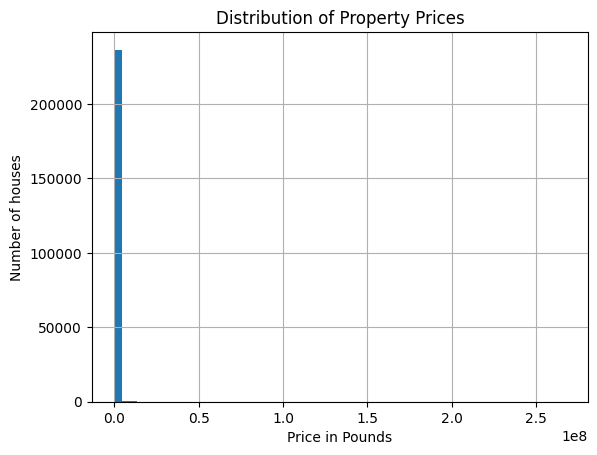

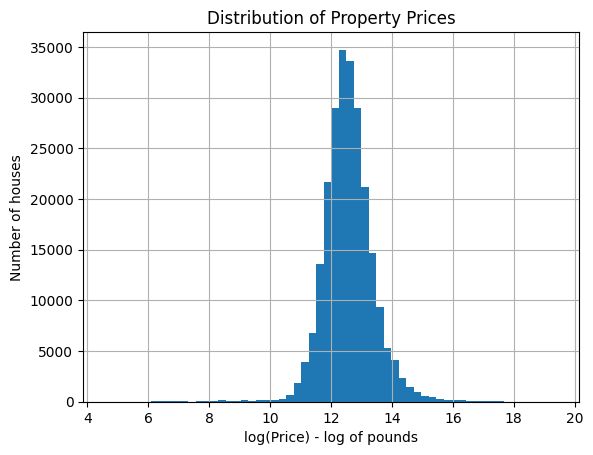

In [56]:
final_df['Price'].hist(bins=60)
plt.xlabel("Price in Pounds")
plt.ylabel("Number of houses")
plt.title("Distribution of Property Prices")
plt.show()


np.log(final_df['Price']).hist(bins=60)
plt.xlabel("log(Price) - log of pounds")
plt.ylabel("Number of houses")
plt.title("Distribution of Property Prices")
plt.show()

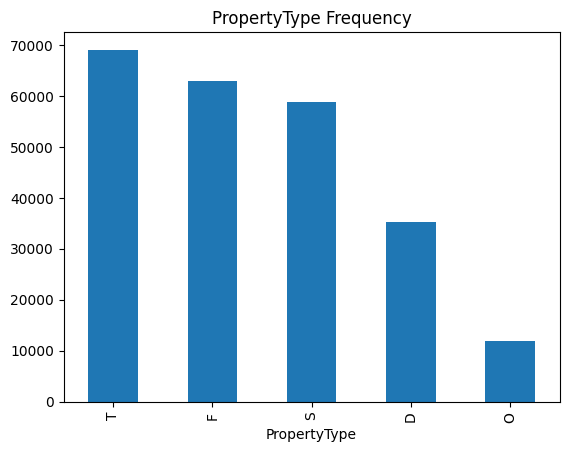

In [106]:
final_df['PropertyType'].value_counts().plot(kind='bar')
plt.title("PropertyType Frequency")
plt.show()

In [107]:
# Average price by Town/City
# High average prices might indicate expensive areas or city centers.
# Low average prices might be smaller towns or less expensive regions.

In [59]:
stats_by_town = filtered_df.groupby(['Town/city']).agg(
    avg_price=('Price','mean'),
    median_price=('Price','median'),
    property_count=('Price','count')
).sort_values('avg_price', ascending=False)

stats_by_town.head(10)

,avg_price,median_price,property_count
Town/city,,,
LONDON,982767.509220,568100.0,55479
CAMBRIDGE,573057.417494,450000.0,3624
READING,514949.142490,400000.0,4674
BRISTOL,435381.758543,340000.0,12437
YORK,410024.206206,302500.0,4544
MILTON KEYNES,406565.590077,346500.0,3769
SOUTHAMPTON,364278.746758,283000.0,5860
NOTTINGHAM,355581.203763,225000.0,11160
SWINDON,344514.982177,272500.0,4152


In [109]:
# Towns with the lowest average distance to station might be highly urban or well-connected.
# Towns with the highest distance values might be more rural.

In [58]:
distance_by_town = filtered_df.groupby(['Town/city']).agg(
    avg_dist_station=('nearest_station_km', 'mean'),
    avg_dist_school_km=('dist_school_km','mean'),
    property_count=('Price','count')
).sort_values('avg_dist_station', ascending=False)
distance_by_town.tail(10)

,avg_dist_station,avg_dist_school_km,property_count
Town/city,,,
STOKE-ON-TRENT,0.141460,0.427210,5856
NOTTINGHAM,0.139177,0.416744,11160
LIVERPOOL,0.138438,0.377259,10223
LONDON,0.135979,0.267403,55479
BRADFORD,0.132522,0.371948,4502
CARDIFF,0.130124,22.192156,4969
SHEFFIELD,0.126116,0.435046,8408
MANCHESTER,0.119700,0.353311,13510
BOLTON,0.119309,0.359744,3923


In [60]:
final_df.loc[final_df['Town/city']=='HATFIELD']

,Price,PropertyType,Old/New,Duration,Town/city,PPD Category Type,nearest_station_km,closest_station,dist_school_km,closest_school,month


## Model Building

In [61]:
y = final_df['Price']
X = final_df.drop(columns=['Price'])

In [62]:
numeric_features = ['nearest_station_km', 'dist_school_km', 'month']
categorical_features = ['PropertyType', 'Old/New', 'Duration', 'Town/city',
                         'PPD Category Type',
                        'closest_station', 'closest_school']

In [63]:
final_df.columns

Index(['Price', 'PropertyType', 'Old/New', 'Duration', 'Town/city',
       'PPD Category Type', 'nearest_station_km', 'closest_station',
       'dist_school_km', 'closest_school', 'month'],
      dtype='object')

### Linear regression

In [64]:

# 4. Build ColumnTransformer and Pipeline
preprocessor = ColumnTransformer([
    ("num", "passthrough", numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

Linear_model_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("regressor", LinearRegression())
])

In [65]:
# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [66]:

# 6. Fit the model
Linear_model_pipeline.fit(X_train, y_train)

# 7. Predict on test set
y_pred_linear = Linear_model_pipeline.predict(X_test)

In [67]:
  # 8. Evaluate
linear_mse = mean_squared_error(y_test, y_pred_linear)  # returns MSE
linear_rmse = linear_mse ** 0.5
linear_r2 = r2_score(y_test, y_pred_linear)

print("Linear Regression RMSE:", linear_rmse)
print("Linear Regression R^2:", linear_r2)

Linear Regression RMSE: 2212703.028364205
Linear Regression R^2: 0.03675378605839741


In [68]:
model_path = os.path.join(model_dir, 'linear_pipeline_2025-04-27.joblib')

joblib.dump(Linear_model_pipeline, model_path)
print(f'Model saved to {model_path}')

Model saved to /content/drive/My Drive/data science project/models/linear_pipeline_2025-04-27.joblib


### Loading the saved model

In [69]:
model_path = os.path.join(model_dir, 'linear_pipeline_2025-04-27.joblib')
loaded_pipeline = joblib.load(model_path)

# confirm it works
y_pred_linear_load = loaded_pipeline.predict(X_test)

  # 8. Evaluate
linear_mse1 = mean_squared_error(y_test, y_pred_linear_load)  # returns MSE
linear_rmse1 = linear_mse1 ** 0.5
linear_r21 = r2_score(y_test, y_pred_linear_load)

print("Linear Regression RMSE:", linear_rmse1)
print("Linear Regression R^2:", linear_r21)

Linear Regression RMSE: 2212703.028364205
Linear Regression R^2: 0.03675378605839741


##### As the target column 'Price' is left skewed , I am performing Log Transformation to make the price column symmetric

In [70]:
final_df['log_price'] = np.log(final_df['Price'])

y_log = final_df['log_price']
X_log = final_df.drop(columns=['Price','log_price'])

In [71]:

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42
)

# 6. Fit the model
Linear_model_pipeline.fit(X_train_log, y_train_log)


y_pred_log = Linear_model_pipeline.predict(X_test_log)

# 7. Exponentiate predictions to revert to original scale
y_pred_exp = np.exp(y_pred_log)   # inverse of log
y_test_exp = np.exp(y_test_log)

# 8. Compute RMSE on original price scale
mse_log = mean_squared_error(y_test_exp, y_pred_exp)
rmse_log = mse_log ** 0.5
r2_log = r2_score(y_test_exp, y_pred_exp)  # R2 defines how good is the model

print("Log-Transformed Linear Regression RMSE:", rmse_log)
print("Log-Transformed Linear Regression R^2:", r2_log)

Log-Transformed Linear Regression RMSE: 2237357.7804615772
Log-Transformed Linear Regression R^2: 0.015168508583321305


### Decision Tree

In [72]:
preprocessor = ColumnTransformer([
    ("num", "passthrough", numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

dt_reg = DecisionTreeRegressor(
    max_depth=None,  # You can tune this
    random_state=27
)

dt_model_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("dt_reg", dt_reg)
])

In [73]:
dt_model_pipeline.fit(X_train, y_train)

dt_y_pred = dt_model_pipeline.predict(X_test)


dt_mse = mean_squared_error(y_test, dt_y_pred)
dt_rmse = np.sqrt(dt_mse)

dt_r2 = r2_score(y_test, dt_y_pred)

print("Decision Tree RMSE:", dt_rmse)
print("Decision Tree R^2:", dt_r2)

Decision Tree RMSE: 1820725.6702565304
Decision Tree R^2: 0.34780107164279617


### Grid search approach for decision tree

In [74]:


param_grid = {
    'dt_reg__max_depth': [5, 10, 20, None],
    'dt_reg__min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(
    dt_model_pipeline, param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best RMSE (CV):", -grid_search.best_score_)

best_model = grid_search.best_estimator_


Best params: {'dt_reg__max_depth': 5, 'dt_reg__min_samples_leaf': 10}
Best RMSE (CV): 2003972.590785142


In [75]:
y_pred_best_dt = best_model.predict(X_test)
#best_rmse = mean_squared_error(y_test, y_pred_best, squared=False)
best_mse_dt = mean_squared_error(y_test, y_pred_best_dt)
best_rmse_dt = np.sqrt(best_mse_dt)
best_r2_dt = r2_score(y_test, y_pred_best_dt)

print("Best Decision Tree RMSE:", best_rmse_dt)
print("Best Decision Tree R^2:", best_r2_dt)


Best Decision Tree RMSE: 2091814.2432485735
Best Decision Tree R^2: 0.13913057837551546


### XGBOOST

In [ ]:

xgb_reg = XGBRegressor(
    n_estimators=100,   # you can tune these
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

xg_model_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("xgb", xgb_reg)
])

In [ ]:
xg_model_pipeline.fit(X_train, y_train)

y_pred_xg = xg_model_pipeline.predict(X_test)

In [ ]:
xg_mse = mean_squared_error(y_test, y_pred_xg)
xg_rmse = np.sqrt(xg_mse)

xg_r2 = r2_score(y_test, y_pred_xg)

print("XGBoost RMSE:", xg_rmse)
print("XGBoost R^2:", xg_r2)

XGBoost RMSE: 870976.3738701527
XGBoost R^2: 0.0993010401725769


In [ ]:
param_grid_xg = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 6, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}

grid_search_xg = GridSearchCV(
    estimator=xg_model_pipeline,
    param_grid=param_grid_xg,
    scoring='neg_root_mean_squared_error',  # or 'neg_mean_absolute_error'
    cv=3,  # 3-fold cross-validation
    n_jobs=-1
)

grid_search_xg.fit(X_train, y_train)

print("Best params:", grid_search_xg.best_params_)
print("Best score (CV RMSE):", -grid_search_xg.best_score_)  # negative is returned by default


Best params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 50}
Best score (CV RMSE): 812481.375


In [ ]:
best_model_xg = grid_search_xg.best_estimator_
y_pred_best_xg = best_model_xg.predict(X_test)

best_mse_xg = mean_squared_error(y_test, y_pred_xg)
final_rmse_xg = np.sqrt(best_mse_xg)

#final_rmse = mean_squared_error(y_test, y_pred_best, squared=False)
final_r2_xg = r2_score(y_test, y_pred_best_xg)

print("Tuned XGBoost RMSE:", final_rmse_xg)
print("Tuned XGBoost R^2:", final_r2_xg)

Tuned XGBoost RMSE: 870976.3738701527
Tuned XGBoost R^2: 0.09549260139465332


758599843840.0

### Results

RMSE (Root Mean Squared Error): The lower the RMSE, the closer the predictions are to the actual prices on average.


R² (Coefficient of Determination): The higher the R², the more variance in the target (price) is explained by the model.


XGBoost (Untuned) achieves both the lowest RMSE (tied with the tuned version) and the highest R².

Hence, XGBoost is the best performer among the tested approaches, slightly outperforming the tuned version in terms of R² and clearly outpacing all linear regression and decision tree variants.

Even though tuning typically improves performance, in this case, the untuned XGBoost’s R² is marginally higher, indicating that simple default settings can already produce strong results, potentially due to hyperparameter overlap or a local optimum in the grid search. For practical purposes, either XGBoost variant outperforms the other models, but XGBoost (Untuned) is the top in raw metrics.









In [ ]:
results_data = {
    'Model': [
        'Linear Regression',
        'Log-Transformed Linear Regression',
        'Decision Tree',
        'Decision Tree (Grid search)',
        'XGBoost',
        'XGBoost (Grid search)'
    ],
    'RMSE': [
        linear_rmse,
        rmse_log,
        dt_rmse,
        best_rmse_dt,
        xg_rmse,
        final_rmse_xg
    ],
    'R^2': [
        linear_r2,
        linear_r2,
        dt_r2,
        best_r2_dt,
        xg_r2,
        final_r2_xg
    ]
}

results_df = pd.DataFrame(results_data)
results_df


,Model,RMSE,R^2
0,Linear Regression,932411.990424,-0.032244
1,Log-Transformed Linear Regression,882030.312147,-0.032244
2,Decision Tree,989732.484667,-0.163061
3,Decision Tree (Grid search),887377.009803,0.065061
4,XGBoost,870976.373870,0.099301
5,XGBoost (Grid search),870976.373870,0.095493
